In [2]:
import torch
import torch.nn as nn
import glob
import numpy as np
import cv2 as cv
import argparse
import pandas as pd
import config
import albumentations
from model import model
from utils.helpers import draw_test_segmentation_map, image_overlay
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score
from PIL import Image

In [3]:
            #fcn_resnet50/101
            #model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1, 1))
            #model.aux_classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1))
            
            #deeplabv3_mobilenet_v3_large
            #model.classifier[4] = nn.Conv2d(256, 2, kernel_size=(1, 1))
            #model.aux_classifier[4] = nn.Conv2d(10, 2, kernel_size=(1, 1))

In [3]:
transform = albumentations.Compose([
    albumentations.Normalize(
            mean=[0.45734706, 0.43338275, 0.40058118],
            std=[0.23965294, 0.23532275, 0.2398498],
            always_apply=True)
])

In [4]:
label_colors_list = [
        (0, 0, 0), # BG
        (2, 79, 59), # Wet_Road_Region
        (17, 163, 74), # Road_region
        (112, 84, 62), # Mud
        (225, 148, 79), # Earthen_Patch
        (120, 114, 104), # Mountain-stones
        (166, 130, 95), # Dirt
        (128, 222, 91), # Vegitation_Misc
        (119, 61, 128), # Distressed_Patch
        (93, 86, 176), # Drainage_Grate
        (140, 160, 222), # Water_puddle
        (234, 133, 5), #Speed_Breaker
        (156, 28, 39), # Misc 
        (99, 122, 130), # Gravel_Patch 
        (123, 43, 31), # Concrete_Material
    ]

def color_to_class(label, label_colors_list):
    label_colors_array = np.array([list(label_color) for label_color in label_colors_list])
#     label_colors_array = label_colors_array[:,::-1]
    labels_array = np.zeros_like(label[:,:,:,0])
    partial_array = np.zeros_like(labels_array)

    for k in range(len(label_colors_list)):
        parital_array = 0
        partial_array[np.where(label[:,:,:,0]==label_colors_array[k,0])] = k
        partial_array[np.where(label[:,:,:,1]!=label_colors_array[k,1])] = 0
        partial_array[np.where(label[:,:,:,2]!=label_colors_array[k,2])] = 0
        labels_array += partial_array
    
    return labels_array

def class_to_color(output_array, label_colors_list):
    label_colors_array = np.array([list(label_color) for label_color in label_colors_list])
    label_colors_array = label_colors_array[:,::-1]
    label_array = np.zeros(list(output_array.shape)+[3])
    for k in range(len(label_colors_list)):
        label_array[np.where(output_array==k)] = label_colors_array[k]
    return label_array.astype('int')

def vector_to_class(output_array):
    return np.argmax(output_array, axis=1)

def intersection_over_union(output_array, label_array, class_number):
    tp = np.sum((output_array==class_number)&(label_array==class_number))
    fn = np.sum((output_array==class_number)&(label_array!=class_number))
    return tp/(np.sum(output_array==class_number)+fn)

In [8]:
root = "/home/adnan/Atif/Misc/Anomaly-Seg/Dataset/Labeled/RSD/"
dim = (256, 144)
cp = glob.glob('/home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/*.pth')

for i in cp:
    checkpoint = torch.load(i, map_location='cuda:0')
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval().to(config.DEVICE)
    criterion = nn.CrossEntropyLoss()
    
    temp = []
    list_miou = []
    data = glob.glob(f'{root}/test/*.jpg')
    for k,j in enumerate(data):
        print('\r'+ f'Computing... {i}: '  + str(k)+'/'+str(len(data)), end="")
        name = j.split('test/')[1]
        image = np.array(Image.open(j).convert('RGB').resize(dim))
        label = np.array(Image.open(f'{root}/test_labels/{name}___fuse.png').convert('RGB').resize(dim)) 
        org_image = image
        image = transform(image=image)['image']
        image = np.transpose(image, (2, 0, 1))
        image = torch.tensor(image, dtype=torch.float)
        image = image.unsqueeze(0).to(config.DEVICE)

        outputs = model(image)
        segmented_image = draw_test_segmentation_map(outputs['out'])
        output_array = color_to_class(np.expand_dims(segmented_image, axis=0), label_colors_list)
        label_array = color_to_class(np.expand_dims(label, axis=0), label_colors_list)
        label_2 = class_to_color(label_array, label_colors_list)
        
        temp = []
        for k in range(len(label_colors_list)):
            pred_per_class = intersection_over_union(output_array, label_array, k)
            iou = intersection_over_union(output_array, label_array, k)
            temp.append(iou)
        temp = np.array(temp)
        miou = np.sum(temp[np.where(np.isnan(temp)==False)])/(15 - np.sum(np.isnan(temp)))
        list_miou.append(miou)
    print(f'  |  MIoU: {sum(list_miou)/len(data)}')

Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_27.pth: 1/4098

/tmp/ipykernel_84487/3377960497.py:48: RuntimeWarning: invalid value encountered in long_scalars
  return tp/(np.sum(output_array==class_number)+fn)


Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_27.pth: 4097/4098  |  MIoU: 0.5013536835806294
Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_10.pth: 4097/4098  |  MIoU: 0.49964578054064773
Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_17.pth: 4097/4098  |  MIoU: 0.5022762688479746
Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_32.pth: 4097/4098  |  MIoU: 0.509387139184376
Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_23.pth: 4097/4098  |  MIoU: 0.5065771055669807
Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_29.pth: 4097/4098  |  MIoU: 0.5131279424205504
Computing... /home/adnan/Atif/Misc/Anomaly-Seg/Code/checkpoints/Experiment-3/wo_32K/model_9.pth: 4097/4098  |  MIoU: 0.49039567636476566
Computing... /home/adnan/Atif/Misc/Anomal

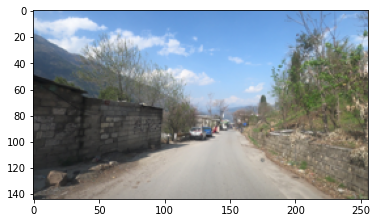

In [29]:
plt.imshow(org_image)

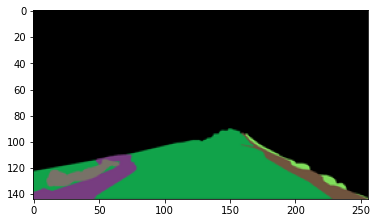

In [30]:
plt.imshow(label)

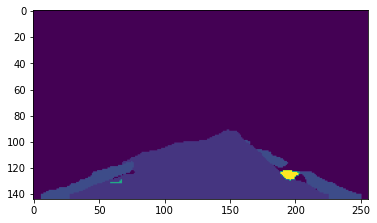

In [31]:
plt.imshow(np.argmax(outputs['out'].detach().cpu().numpy(), axis=1)[0])

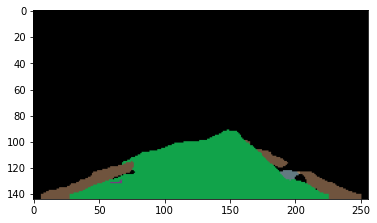

In [32]:
plt.imshow(segmented_image)

In [19]:
outputs['out'][0,0,:10,0]

tensor([23.8471, 23.8471, 23.8471, 23.8471, 26.5746, 32.0296, 37.4846, 42.9396,
        48.3946, 53.8496], device='cuda:0', grad_fn=<SelectBackward0>)

In [27]:
segmented_image.shape, label.shape

((144, 256, 3), (144, 256, 3))